In [1]:
# Package installations
from IPython.utils import io
with io.capture_output() as captured:
  !pip install gdown
  !pip3 install pillow==8.2.0
  !pip install neptune-client
  !pip install neptune-client neptune-tensorboard
  !pip install neptune-contrib

In [2]:
import neptune
NEPTUNE_TOKEN = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMGUxMmQ1NC00ZDU4LTQ4ZGYtOWJjOC0xYTJkYjJmYmJiZDMifQ=='
run = neptune.init(project_qualified_name='ch.kalavritinos/kvasir-cls', api_token=NEPTUNE_TOKEN)

In [3]:
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MAI/thesis/source

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MAI/thesis/source


In [4]:
# %cd /content/

In [5]:
# !git clone https://github.com/simula/hyper-kvasir.git

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os

# Kvasir dataloaders


In [7]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [8]:
test_dir = os.path.join(os.getcwd(),'kvasir-dataset-v2-folds/1/test')
train_dir = os.path.join(os.getcwd(),'kvasir-dataset-v2-folds/1/train')

In [9]:
def get_data_loader(data_dir, batch_size=32, train=True):
    # define how we augment the data for composing the batch-dataset in train and test step
    transform = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(90),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    # ImageFolder with root directory and defined transformation methods for batch as well as data augmentation
    if train:
      data = ImageFolderWithPaths(root=data_dir, transform=transform['train'])
    else:
      data = ImageFolderWithPaths(root=data_dir, transform=transform['test'])
    data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True, num_workers=2)

    return data.class_to_idx, data_loader 

In [10]:
torch.multiprocessing.freeze_support()
mapping, train_data_loader = get_data_loader(data_dir=train_dir, batch_size=32, train=True)
mapping, test_data_loader = get_data_loader(data_dir=test_dir, batch_size=32, train=False)

In [11]:
import pathlib
train_data_dir = pathlib.Path(train_dir)
test_data_dir = pathlib.Path(test_dir)

In [12]:
total_train = len(list(train_data_dir.glob('*/*.jpg')))
total_val = len(list(test_data_dir.glob('*/*.jpg')))
total_train, total_val

(7200, 800)

In [13]:
#get the class names
CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['normal-pylorus', 'polyps', 'normal-z-line', 'normal-cecum',
       'esophagitis', 'dyed-lifted-polyps', 'dyed-resection-margins',
       'ulcerative-colitis'], dtype='<U22')

In [14]:
# Define parameters for training
dataset = 'kvasirv2'
batch_size = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(total_train/batch_size)
num_classes = len(CLASS_NAMES) # 8

epochs = 16
lr = 0.001
disp_interval = 100
weight_decay = 0.0005
decay_points = '5, 10'

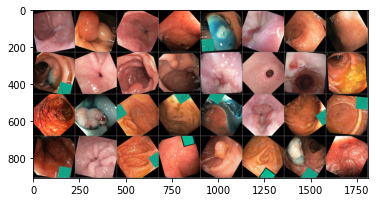

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_data_loader)
images, labels, _ = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [16]:
images.max()

tensor(1.)

In [17]:
%cd OAA

/content/drive/MyDrive/MAI/thesis/source/OAA


# vgg.py


In [18]:
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo        # Loads the Torch serialized object at the given URL
import torch.nn.functional as F
import math
import cv2
import numpy as np
import os

model_urls = {'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth'}      # dict with standard VGG from online directory

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True, att_dir='./results_voc/', training_epoch=15):
        super(VGG, self).__init__()
        self.features = features
        self.nclasses = num_classes
        self.extra_convs = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512,num_classes,1)                    # include 4 new conv layers, last one has 8 outputs for the 8 classes
        )
        self._initialize_weights()
        self.training_epoch = training_epoch
        self.att_dir = att_dir
        if not os.path.exists(self.att_dir):
            os.makedirs(self.att_dir)

    def forward(self, x, epoch=1, label=None, index=None):
        x = self.features(x)
        x = self.extra_convs(x)
        self.map1 = x.clone()
        x = F.avg_pool2d(x, kernel_size=(x.size(2), x.size(3)), padding=0)
        x = x.view(-1, self.nclasses)
        
        ###  the online attention accumulation process
        pre_probs = x.clone()
        probs = torch.sigmoid(pre_probs)  # compute the prob
        
        if index != None and epoch > 0:
            atts = self.map1
            atts[atts < 0] = 0
            ind = torch.nonzero(label)

            for i in range(ind.shape[0]):
                batch_index, la = ind[i]
                accu_map_name = '{}{}_{}.png'.format(self.att_dir, batch_index+index, la)
                att = atts[batch_index, la].cpu().data.numpy()
                att = att / (att.max() + 1e-8) * 255
                
                # if this is the last epoch and the image without any accumulation
                if epoch == self.training_epoch - 1 and not os.path.exists(accu_map_name):
                    cv2.imwrite(accu_map_name, att)
                    continue
                
                # naively filter out the low quality attention map with prob
                if probs[batch_index, la] < 0.1:  
                    continue
                # print(f'accu_map_name:{accu_map_name}')
                if att is not None:
                    if not os.path.exists(accu_map_name):
                        cv2.imwrite(accu_map_name, att)
                else:
                    accu_att = cv2.imread(accu_map_name, 0)
                    if att is not None:
                        if accu_att is not None:
                            accu_att = np.maximum(accu_att, att)
                            cv2.imwrite(accu_map_name,  accu_att)
         ##############################################

        return x

    def get_heatmaps(self):
        return self.map1

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
    
    def get_parameter_groups(self):
        groups = ([], [], [], [])

        for name, value in self.named_parameters():

            if 'extra' in name:
                if 'weight' in name:
                    groups[2].append(value)
                else:
                    groups[3].append(value)
            else:
                if 'weight' in name:
                    groups[0].append(value)
                else:
                    groups[1].append(value)
        return groups


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for i, v in enumerate(cfg):
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'N':
            layers += [nn.MaxPool2d(kernel_size=3, stride=1, padding=1)]
        else:
            if i > 13:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, dilation=2, padding=2)            
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'D1': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'N', 512, 512, 512],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg16(pretrained=False, **kwargs):        # input arg: num classes
    model = VGG(make_layers(cfg['D1']), **kwargs)  
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16']), strict=False)      # get pretrained VGG from URL
    return model

# Train loop

In [19]:
# from models import vgg
def get_model(lr=0.001):
    """Function for getting VGG16"""
    model = vgg16(pretrained=True, num_classes=num_classes, training_epoch=epochs)
    model = torch.nn.DataParallel(model).cuda()                         # parallel GPU training
    param_groups = model.module.get_parameter_groups()

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    return  model, optimizer

In [20]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

model, optimizer = get_model()                      # call get_model(), get modified VGG and optimizer
criterion = torch.nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=5, verbose=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [21]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):     # save points during training
    """Function for saving checkpoints"""
    savepath = os.path.join(snapshot_dir, filename)
    print(savepath)
    torch.save(state, savepath)
    print(f"Model saved to {savepath}")
    
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']+1, checkpoint['global_counter']

In [25]:
def validate(model, criterion):
  model.eval()
  corrects = 0
  total_sum = 0
  total_loss = 0.0
  with torch.no_grad():
      for idx, dat in enumerate(test_data_loader,0):
          imgs, lbls, _ = dat
          imgs = imgs.to(device)
          lbls = lbls.to(device)

          outputs = model(imgs)
          val_loss = criterion(outputs, lbls)

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total_sum += lbls.size(0)
          corrects += (predicted == lbls).sum().item()
          total_loss += loss.item()

  print('Acc val set: %f %%' % (
      100 * corrects / total_sum))
  print('Val loss: ', float(val_loss.cpu().numpy()))
  average_loss = total_loss / total_samples
  neptune.log_metric('val_loss', average_loss)
  return average_loss

In [23]:
snapshot_dir = '/content/drive/MyDrive/MAI/thesis/source/OAA/checkpoints/train/exp9/'

In [26]:
global_counter = 0
best_val_loss = float('inf')
current_epoch = 0

print('Training started ...')
PARAMS = {'dataset':dataset,
            'network':'vgg16',
            'epoch_nr': epochs,
            'batch_size': batch_size,
            'optimizer': 'SGD',
            'lr': lr
      }
neptune.create_experiment('kvasirv2_train', params=PARAMS)

while current_epoch < epochs:  # loop over the dataset multiple times
    total_loss = 0.0
    corrects = 0
    total_samples = 0
    for idx, dat in enumerate(test_data_loader,0):
        inputs, labels, fname = dat
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        corrects += torch.sum(predicted == labels)
        total_samples += labels.size(0)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        global_counter += 1

        # print statistics
        total_loss += loss.item()
        if idx % disp_interval == disp_interval-1:    # print every X mini-batches
            print('[%d, %5d] loss: %.3f, corrects: %d' %
                  (current_epoch + 1, idx + 1, total_loss/disp_interval, corrects))
            neptune.log_metric('train_loss', total_loss/disp_interval)
            neptune.log_metric('lr', optimizer.param_groups[0]['lr'])
            total_loss = 0.0
    average_accuracy = 100 * corrects / total_samples
    average_loss = total_loss / total_samples

    val_loss = validate(model, criterion)
    scheduler.step(val_loss)
    neptune.log_metric('epoch_train_acc', average_accuracy)
    print('Avg accuracy: ', average_accuracy)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_checkpoint(
                      {'epoch': current_epoch,
                        'global_counter': global_counter,
                        'state_dict':model.state_dict(),
                        'optimizer':optimizer.state_dict()
                      },
                      filename='%s_epoch_%d.pth' %(dataset, current_epoch))
    
    if current_epoch == epochs-1:
        save_checkpoint(
                        {
                            'epoch': current_epoch,
                            'global_counter': global_counter,
                            'state_dict':model.state_dict(),
                            'optimizer':optimizer.state_dict()
                        },
                        filename='%s_epoch_%d.pth' %(dataset, current_epoch))
        
    current_epoch += 1

print('Finished Training')

Training started ...
https://app.neptune.ai/ch.kalavritinos/kvasir-cls/e/KVAS-25
Acc val set: 79.625000 %
Val loss:  0.31129884719848633
Avg accuracy:  tensor(68.7500, device='cuda:0')
/content/drive/MyDrive/MAI/thesis/source/OAA/checkpoints/train/exp9/kvasirv2_epoch_0.pth
Model saved to /content/drive/MyDrive/MAI/thesis/source/OAA/checkpoints/train/exp9/kvasirv2_epoch_0.pth
Acc val set: 87.250000 %
Val loss:  0.2633591592311859
Avg accuracy:  tensor(81.1250, device='cuda:0')
/content/drive/MyDrive/MAI/thesis/source/OAA/checkpoints/train/exp9/kvasirv2_epoch_1.pth
Model saved to /content/drive/MyDrive/MAI/thesis/source/OAA/checkpoints/train/exp9/kvasirv2_epoch_1.pth
Acc val set: 93.000000 %
Val loss:  0.2413162887096405
Avg accuracy:  tensor(89., device='cuda:0')
/content/drive/MyDrive/MAI/thesis/source/OAA/checkpoints/train/exp9/kvasirv2_epoch_2.pth
Model saved to /content/drive/MyDrive/MAI/thesis/source/OAA/checkpoints/train/exp9/kvasirv2_epoch_2.pth
Acc val set: 96.125000 %
Val loss:

In [ ]:
for idx, dat in enumerate(train_data_loader,0):
  imgs, lbls, fname = dat
  break

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

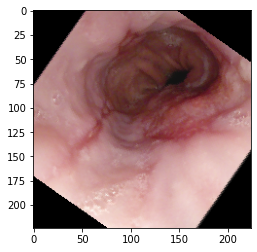

In [ ]:
imshow(dat[0][6])

In [ ]:
outputs = model(imgs)         # get model output
_, predicted = torch.max(outputs.data, 1)

In [ ]:
from sklearn.metrics import confusion_matrix

preds_total = torch.tensor([])
labels_total = torch.tensor([])
with torch.no_grad():
  for idx, dat in enumerate(test_data_loader,0):
            imgs, lbls, fname = dat
            imgs = imgs.to(device)         # to cpu
            lbls = lbls.to(device)         # same
            outputs = model(imgs)         # get model output
            _, predicted = torch.max(outputs.data, 1)

            preds_total = torch.cat((preds_total, predicted.cpu()), dim=0)
            labels_total = torch.cat((labels_total, labels.cpu()), dim=0)

cm_val = confusion_matrix(preds_total.view(-1), labels_total.view(-1))

Text(33.0, 0.5, 'Predicted classes')

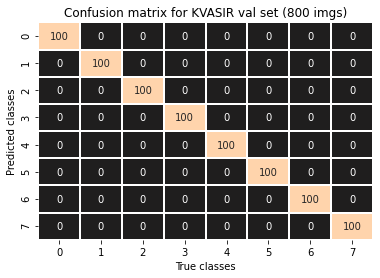

In [ ]:
import seaborn as sns
ax = plt.axes()
sns.heatmap(cm_val, annot=True, fmt='d', cbar=False, linewidth=1, center=0)
ax.set_title('Confusion matrix for KVASIR val set (800 imgs)')
ax.set_xlabel('True classes')
ax.set_ylabel('Predicted classes')

In [ ]:
from sklearn.metrics import confusion_matrix

preds_total = torch.tensor([])
labels_total = torch.tensor([])
with torch.no_grad():
  for idx, dat in enumerate(train_data_loader,0):
            imgs, lbls, fname = dat
            imgs = imgs.to('cpu')         # to cpu
            lbls = lbls.to('cpu')         # same
            outputs = model(imgs)         # get model output
            _, predicted = torch.max(outputs.data, 1)

            preds_total = torch.cat(
              (preds_total, predicted.to('cpu'))
              ,dim=0)
            labels_total = torch.cat(
              (labels_total, lbls)
              ,dim=0)

cm_train = confusion_matrix(preds_total.view(-1), labels_total.view(-1))

Text(33.0, 0.5, 'Predicted classes')

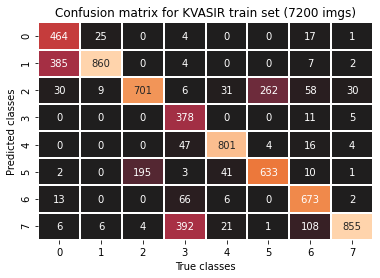

In [ ]:
import seaborn as sns
ax = plt.axes()
sns.heatmap(cm_train, annot=True, fmt='d', cbar=False, linewidth=1, center=0)
ax.set_title('Confusion matrix for KVASIR train set (7200 imgs)')
ax.set_xlabel('True classes')
ax.set_ylabel('Predicted classes')

In [ ]:
# globl_counter = 0
# crf_alpha = [4,24]
# for idx, dat in enumerate(test_data_loader,0):
#           imgs, lbls, fname = dat
#           imgs = imgs.to('cpu')         # to cpu
#           lbls = lbls.to('cpu')         # same
#           outputs = model(imgs)         # get model output
#           _, predicted = torch.max(outputs.data, 1)     # predict label

#           last_featmaps = model.get_heatmaps()          # get featmap
#           for im in range(batch_size):                  # for all images in batch calculate attention
#             orig_img = imgs[im].numpy()

#             orig_img = np.transpose(orig_img, (1, 2, 0))
#             orig_img_size = orig_img.shape[:2]
#             height, width = orig_img_size[0], orig_img_size[1]

#             cam_dict = {}
#             maps = last_featmaps[im].cpu().data.numpy()        # get heatmap of label (single label)
#             cv_im_gray = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)       # make it gray
#             cv_im_gray = cv2.resize(cv_im_gray, (width, height), interpolation = cv2.INTER_CUBIC)

#             labels = lbls.cpu().long().numpy()                            # get label
            
#             att = maps[predicted[im]]                                     # get the heatmap and start processing
#             att[att < 0] = 0
#             att = att / (np.max(att) + 1e-5)
#             cam_max = np.max(att)
#             cam_min = np.min(att)

#             norm_cam = cv2.resize(att, (width, height), interpolation = cv2.INTER_CUBIC)      # normalize to 0 to 1 
#             norm_cam = (norm_cam-cam_min-1e-5) / (cam_max  - cam_min + 1e-5)
#             cam_dict[predicted[im]] = norm_cam                                                # build dictionary
#             att = np.array(att * 255, dtype=np.uint8)                                         # make to image

#             fname_new = fname[im].split('/')
#             im_name = save_dir + fname_new[-1][0:-4]
#             globl_counter += 1

#             out_name = im_name + '_{}.png'.format(predicted[im])                              # just save the image (name is random)
#             # att = cv2.resize(att, (width, height), interpolation=cv2.INTER_CUBIC)
#             # att = cv_im_gray * 0.3 + att * 0.7

#             if not os.path.exists(save_dir):
#                     os.makedirs(save_dir)

#             # plt.imsave(out_name, att, cmap=colormap(labels[im])) 

#             if out_cam is not None:
#                 if not os.path.exists(out_cam):
#                     os.makedirs(out_cam)
#                 # np.save(os.path.join(out_cam, fname_new[-1][0:-4] + '.npy'), cam_dict)        # save dictionary at ./results_cam

#             if out_crf is not None:
#                 if not os.path.exists(out_crf):
#                     os.makedirs(out_crf)
#                 for t in crf_alpha:
#                     crf = _crf_with_alpha(orig_img, cam_dict, t)
#                     folder = out_crf + ('_%.1f'%t)
#                     if not os.path.exists(folder):
#                         os.makedirs(folder)
#                     # np.save(os.path.join(folder, fname_new[-1][0:-4] + '.npy'), crf)
#             break
            


In [ ]:
# confusion_matrix = torch.zeros(nb_classes, nb_classes)
# with torch.no_grad():
#     for i, (inputs, classes) in enumerate(dataloaders['val']):
#         inputs = inputs.to(device)
#         classes = classes.to(device)
#         outputs = model_ft(inputs)
#         _, preds = torch.max(outputs, 1)
#         for t, p in zip(classes.view(-1), preds.view(-1)):
#                 confusion_matrix[t.long(), p.long()] += 1

In [ ]:
# snapshot_dir = os.path.join(os.getcwd(),'checkpoints/train/exp8')
# snapshot_dir = '/content/drive/MyDrive/MAI/thesis/source/OAA/checkpoints/train/exp8/'